# Data Visualizations
Submitted by: Samantha Roska, Rebecca Hailperin-Lausch, and Samantha Russel

This file contains the visualizations we created to explore and understand the relationship between women in world governing bodies and world country democratic index scores, using the cleaned data files obtained and created in data_cleaning.ipynb

In [23]:
#importing in libraries
import numpy as np
import pandas as pd
import glob
import re
import warnings
import nbformat

#chloropleth libraries
import plotly.graph_objects as go
import plotly.express as px

#bar chart libraries
import matplotlib.pyplot as plt
import seaborn as sns
import math
import matplotlib.patches as mpatches

#set seaborn theme as default
sns.set_theme()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [24]:
#defining function to rename countries
def change_countries(x, countries):
    '''makes countries consistent across dataframes'''
    for country,variations in countries.items():
        for variation in variations.values():
            if x == variation:
                return country
    return x

## Analysis 1: Exploring democracy index score variables and women in government variables through box plots and histograms

To obtain context about the variables we are exploring in our analysis, we created boxplots and histograms. This allowed us to visualize their distributions as a starting point.

### Box Plot of democracy index data

In [25]:
# read in democracy data
dem_idx = pd.read_csv('./data/democracy_index_data.csv')

# create box plot
fig = px.box(dem_idx,
            y="five_year_mean",
            color="region",
            template='plotly_white',
            color_discrete_sequence=px.colors.qualitative.Prism,
            title= 'Box Plots of the Democracy Index Score by Region',
            width=800,
            height=400,
            )
fig.update_yaxes(title_text='Democracy Index Score (5 year mean)')
fig.show()

### Histogram of women in government data

In addition to having the percent women in parliments for each country for each year, it is helpful to look at the most recent data (only 2022). 

In [26]:
#read in data
women = pd.read_csv('./data/world_data_final.csv')

# convert to datetime
women['lower_single_house_elections'] = pd.to_datetime(women['lower_single_house_elections'])
women['upper_house_senate_elections_year'] = pd.to_datetime(women['upper_house_senate_elections'])

# get 2022 data
women2022 = women[(women['lower_single_house_elections'].dt.year== 2022)|(women['upper_house_senate_elections_year'].dt.year== 2022)]

# melt dataframe and rename columns (to look better in the visualization)
women_melted = women2022.reset_index().melt(id_vars=['country'],value_vars=['lower_single_house_percent_w','upper_house_senate_percent_w'],value_name='Percent Women',var_name='House')

# convert to percents (to look better in the visualization)
women_melted['Percent Women'] = round(women_melted.loc[:,'Percent Women']*100,2).astype(float)

In [27]:
# make histogram
fig = px.histogram(women_melted, x='Percent Women',
                    facet_col='House',
                    nbins=10,
                    width=800,
                    height=400,
                    template='plotly_white',
                    color_discrete_sequence=[px.colors.qualitative.Prism[1],px.colors.qualitative.Prism[2]],
                    title= 'Histogram of the Percent Women in Parliaments in Countries across the World in 2022',)

facet_titles = ['Lower Houses','Upper Houses']
for i, a in enumerate(fig.layout.annotations):
    a.text = facet_titles[i]

fig.show()

## Analysis 2: Exploring democracy index scores around the world

Next, we wanted to explore how democracy index scores differed around the world and over time. To do this, we created a world map cloropleth.

In [28]:
dem_index= pd.read_csv('./data/democracy_index_data.csv')
dem_index.columns = dem_index.columns.str.lower()

country_codes = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_world_gdp_with_codes.csv')

country_codes = country_codes[['COUNTRY','CODE']]
country_codes.columns = country_codes.columns.str.lower()
df = pd.merge(dem_index,country_codes, on='country',how ="left")
df.shape

(167, 21)

In [29]:
#Finding the ISO codes that are empty after the merge
df[df['code'].isna()].head()

region  2022_rank          country       regime_type  \
40   Central and Eastern Europe         72  North Macedonia  Flawed democracy   
89         Asia and Australasia        166          Myanmar     Authoritarian   
92         Asia and Australasia        165      North Korea     Authoritarian   
97         Asia and Australasia         24      South Korea    Full democracy   
101        Asia and Australasia         44       East Timor  Flawed democracy   

     2022  2021  2020  2019  2018  2017  2016  2015  2014  2013  2012  2011  \
40   6.10  6.03  5.89  5.97  5.87  5.57  5.23  6.02  6.25  6.16  6.16  6.16   
89   0.74  1.02  3.04  3.55  3.83  3.83  4.20  4.14  3.05  2.76  2.35  1.77   
92   1.08  1.08  1.08  1.08  1.08  1.08  1.08  1.08  1.08  1.08  1.08  1.08   
97   8.03  8.16  8.01  8.00  8.00  8.00  7.92  7.97  8.06  8.06  8.13  8.06   
101  7.06  7.06  7.06  7.19  7.19  7.19  7.24  7.24  7.24  7.24  7.16  7.22   

     2010  2008  2006  five_year_mean code  
40   6.16  6.21  6.33           5.972  NaN  
89   1.77  1.77  1.77           2.436  NaN  
92   1.08  0.86  1.03           1.080  NaN  
97   8.11  8.01  7.88           8.040  NaN  
101  7.22  7.22  6.41           7.112  NaN

In [30]:
# https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes

missinf_df = df[df['code'].isna()]
drop_indexes = missinf_df.index
df2 = df.drop(index=[40, 89, 92, 97, 101, 115, 128, 133, 134, 135, 139, 142]).copy()


update_codes = { 'country': ['North Macedonia','Myanmar','East Timor','South Korea','North Korea','Palestine','Cape Verde','Republic of the Congo','Ivory Coast','Democratic Republic of the Congo','Eswatini','Gambia'] ,
                    'code':['MKD','MMR', 'TLS', 'KOR', 'PRK', 'PST', 'CPV','COG', 'CIV', 'COD', 'SWZ', 'GMB']}

temp_df = pd.DataFrame.from_dict(update_codes)
update_codes = pd.merge(missinf_df,temp_df, on='country', how='left')
update_codes = update_codes.drop(columns='code_x')
update_codes = update_codes.rename(columns={'code_y':'code'})

final_df = pd.concat([df2,update_codes])
final_df.shape

(167, 21)

Full democracies
  - 9.01–10.00 : #200211
  - 8.01–9.00 : '#5d0e1a'

Flawed democracies
  - 7.01–8.00 : #9b3327'
  - 6.01–7.00 : '#e3754f'

Hybrid regimes
  - 5.01–6.00 : '#f1b26e'
  - 4.01–5.00 : '#f9e096'

Authoritarian regimes
  - 3.01–4.00 : '#b2d878'
  - 2.01–3.00 : '#7bbb6d'
  - 1.01–2.00 : #489657
  - 0.00–1.00 : #2b6619

In [31]:
index_colors = ['#200211','#5d0e1a','#9b3327','#e3754f','#f1b26e','#f9e096','#b2d878','#7bbb6d','#489657','#2b6619']

fig = go.Figure(data=go.Choropleth(
    locations = final_df['code'],
    z = final_df['five_year_mean'],
    text = final_df['country'],
    colorscale = index_colors,
    autocolorscale=False,
    reversescale=False,
    marker_line_color='black',
    marker_line_width=0.5,
    colorbar_title = 'Score<br>(1-10)',
))

fig.update_layout(
    title_text='Democracy Index Score Five year Mean',
    height=700,
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    )
)

fig.show()

In [32]:
years = ['2022', '2021', '2020','2019', '2018', '2017', '2016', '2015', '2014', '2013', '2012', '2011','2010', '2008', '2006']
melt_df = pd.melt(final_df, id_vars =["region","country","code","five_year_mean"], value_vars =years,
              var_name ='year',value_name ='score')
melt_df = melt_df.sort_values('year')
melt_df.head()


region             country code  \
2504               Sub-Saharan Africa              Gambia  GMB   
2396  Latin America and the Caribbean             Ecuador  ECU   
2395  Latin America and the Caribbean  Dominican Republic  DOM   
2394  Latin America and the Caribbean                Cuba  CUB   
2393  Latin America and the Caribbean          Costa Rica  CRI   

      five_year_mean  year  score  
2504           4.402  2006   4.39  
2396           6.026  2006   5.64  
2395           6.448  2006   6.13  
2394           2.784  2006   3.52  
2393           8.144  2006   8.04

In [33]:

fig = px.choropleth(melt_df, 
        locations="code",
        color="score", 
        hover_name="country",
        color_continuous_scale=index_colors,
        hover_data={'year': False, 'five_year_mean': True, 'code': False},
        height=900,
        animation_frame="year",
        title='Democracy Index Score 2006-2022<br>Source: <a href="https://en.wikipedia.org/wiki/Democracy_Index">\
            Democracy Index</a>')

fig.show()

## Analysis 3: Exploring the relationship between these demcoratic index scores and the number of women in governing bodies for each country

From the chloropleth above, we found a wide range of democratic scores for countries around the world. This raised the question, do countries with more women in government have higher democratic index scores, and vice versa?

In [34]:
# comparing using January 2022

#ignore warnings
warnings.filterwarnings('ignore')

# read in necessary data and performing data cleaning
jan_22_data_full = pd.read_csv("data/world_data/wd_1_2022.csv")

cols = jan_22_data_full.iloc[4]

#renaming columns
cols[1] = 'Country'
cols[7] = 'upperseats'
cols[3] = 'lowerseats'
cols[8] = 'upperwomen'
cols[4] = 'lowerwomen'


jan_22_data = jan_22_data_full.iloc[5:]
jan_22_data.columns = cols

#replacing dashes with 0
jan_22_data['upperseats'] = jan_22_data['upperseats'].replace("-",0)
jan_22_data['upperwomen'] = jan_22_data['upperwomen'].replace("-",0)
jan_22_data['lowerseats'] = jan_22_data['lowerseats'].replace("-",0)
jan_22_data['lowerwomen'] = jan_22_data['lowerwomen'].replace("-",0)

#converting column types
jan_22_data['upperseats'] = jan_22_data['upperseats'].astype(int)
jan_22_data['lowerseats'] = jan_22_data['lowerseats'].astype(int)
jan_22_data['upperwomen'] = jan_22_data['upperwomen'].astype(int)
jan_22_data['lowerwomen'] = jan_22_data['lowerwomen'].astype(int)

#creating total columns
jan_22_data['totalseats'] = jan_22_data['lowerseats'] + jan_22_data['upperseats']
jan_22_data['totalwomen'] = jan_22_data['lowerwomen'] + jan_22_data['upperwomen']

#democracy score data
countries = pd.read_csv("data/democracy_index_data.csv")
countries_scores = countries[['country', '2022']]



In [35]:
#select data for graphing and creating total columns
plot_data2 = jan_22_data[['Country', 'totalseats', 'totalwomen']]

plot_data2 =plot_data2[plot_data2['totalseats'] > 0]
plot_data2['W%'] = plot_data2['totalwomen'] /plot_data2['totalseats']

plot_data2['Country'] = plot_data2['Country'].replace("United States of America", "United States")
plot_data2['Country'] = plot_data2['Country'].replace("Bolivia (Plurinational State of)", "Bolivia")

plot_data2 = plot_data2.merge(countries_scores, right_on='country', left_on='Country', how='left')
plot_data2 = plot_data2.dropna(subset=["2022"])

plot_data2['Country'] = plot_data2['Country'].replace("United Arab Emirates", "U.A.E.")

plot_data2 = plot_data2.sort_values("W%", ascending=False).iloc[np.r_[0:10, 64,-11:-1],:]


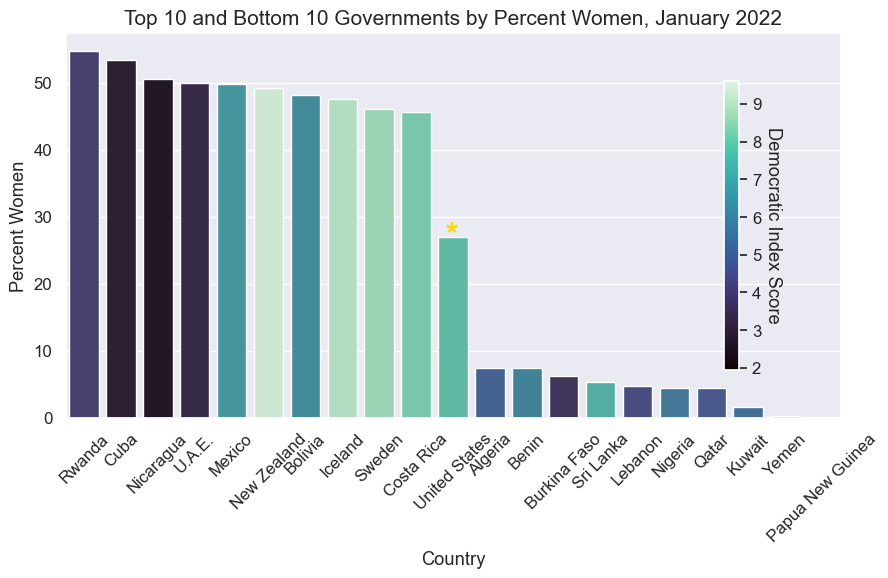

In [36]:
# set the figure size
plt.figure(figsize=(10, 5))
sns.set(font_scale=1.1)

# # from raw value to percentage
women2 = plot_data2.copy()
women2['total_seats'] = [round(i / j * 100,2) for i,j in zip(women2['totalwomen'], plot_data2['totalseats'])]
women2["2022"] = pd.to_numeric(women2["2022"])

#scipt to create continuous legend/colorbar
g = women2.groupby('Country')
rates = g['2022'].mean()
n = g.size()

plot = plt.scatter(n.index, n, c=rates, cmap='mako')
plt.clf()
cbar = plt.colorbar(plot, shrink=0.75)
cbar.ax.get_yaxis().labelpad = 15
cbar.set_label('Democratic Index Score', rotation=270)


#create bar chart
bar = sns.barplot(x="Country", y="total_seats", data=women2, hue='2022', dodge=False, palette='mako')
bar.legend_.remove()

#rotate country labels
bar.set_xticklabels(
    bar.get_xticklabels(),
    rotation=45,
)

#add titles
plt.title("Top 10 and Bottom 10 Governments by Percent Women, January 2022", fontsize=15)
plt.ylabel('Percent Women')

#emphasize U.S. by placing a star on top of the bar
plt.text(9.8, 26, "*", horizontalalignment='left', size='xx-large', color='gold', weight='extra bold')

# show the graph
plt.show()




We're not seeing a clear pattern emerge from this visualization. Let's do a correlation to quantify this relationship at the world level.

### Correlation between percent women in parliaments and democracy index

In order to run the correlation, the datasets need to be joined together into one dataframe. To do this, both datasets need to be reshaped (from wide to long) and both datasets need to have consistent columns to join on, in this case, country and year. As we started doing this, we realized that the datasets had different naming conventions for how they spell certain countries. For instance, one dataset had the US as the 'United States' and the other had it as 'United States of America'. This was true of many other countries as well. The file 'data/list_of_countries.csv' was obtained from [here](https://www.iban.com/country-codes) using pd.read_html(). The 'Country' column of this file will serve as our new standard for both datasets. Next, both datasets were manually inspected and variations in how the countries are spelled were added to the list_of_countries.csv file in the variations columns. Using this file and the custom function 'change_countries', we were able to convert the names of the countries to be consistent across both datasets, which allowed us to join them into one dataframe. 

In [37]:
# read in democracy index data
democracy_index = pd.read_csv('./data/democracy_index_data.csv')
# read in the percent women in parliments data
women_in_parliments =  pd.read_csv('./data/world_data_final.csv')

# get a list of years to be used to melt the dataframe
years_list = [str(year) for year in range(2010,2023)]
years_list.insert(0,'2008')
years_list.insert(0,'2006')
# melt dataframe from wide to long
democracy_index_melted = democracy_index.melt(id_vars=['region','2022_rank','country','regime_type','five_year_mean'],value_vars=years_list,var_name='year',value_name='democracy_index_score')

# groupby so that there is only one value for each year, get only lower house
lower_house = women_in_parliments[['country','lower_single_house_percent_w','lower_single_house_elections_year']].groupby(['country','lower_single_house_elections_year']).apply(lambda x: x['lower_single_house_percent_w'].mean(skipna=False)).dropna().reset_index()
lower_house = lower_house.rename({'lower_single_house_elections_year':'year',0:'lower_single_house_percent_w'},axis=1)
# groupby so that there is only one value for each year, get only upper house
upper_house = women_in_parliments[['country','upper_house_senate_percent_w','upper_house_senate_elections_year']].groupby(['country','upper_house_senate_elections_year']).apply(lambda x: x['upper_house_senate_percent_w'].mean(skipna=False)).dropna().reset_index()
upper_house = upper_house.rename({'upper_house_senate_elections_year':'year',0:'upper_house_senate_percent_w'},axis=1)

# merge upper and lower back together
parliaments = lower_house.merge(upper_house,on=['country','year'], how='outer')

# make sure there is not whitespace in country columns
democracy_index_melted['country'] = democracy_index_melted['country'].str.strip()
parliaments['country']  = parliaments['country'].str.strip()

# read in a list of countries and different spelling variations of those countries
countries = pd.read_csv('./data/list_of_countries.csv')
countries['Variation1'] = countries['Variation1'].astype(str)
countries['Variation2'] = countries['Variation2'].astype(str)
countries['Variation3'] = countries['Variation3'].astype(str)
countries_dict = countries.set_index('Country')[['Variation1','Variation2','Variation3']].to_dict(orient='index')

# make country names in both datasets consistent
parliaments['country'] = parliaments['country'].apply(change_countries,args=(countries_dict,))
democracy_index_melted['country'] = democracy_index_melted['country'].apply(change_countries,args=(countries_dict,))

# join the two datasets on year and country
df = democracy_index_melted.merge(parliaments, on=['country','year'], how='outer')

#### Overall correlation

In [38]:
corr = df[['democracy_index_score','lower_single_house_percent_w','upper_house_senate_percent_w']].corr()
corr

democracy_index_score  \
democracy_index_score                      1.000000   
lower_single_house_percent_w               0.312691   
upper_house_senate_percent_w               0.187139   

                              lower_single_house_percent_w  \
democracy_index_score                             0.312691   
lower_single_house_percent_w                      1.000000   
upper_house_senate_percent_w                      0.628845   

                              upper_house_senate_percent_w  
democracy_index_score                             0.187139  
lower_single_house_percent_w                      0.628845  
upper_house_senate_percent_w                      1.000000

#### Correlation by region

There's a weak, positive correlation between democracy index scores and the percent of women in government at a national level. What happens when we do this correlation by region, to account for possible regional differences such as different cultural expectations for women?

In [39]:
corr_by_region = df.groupby('region')[['democracy_index_score','lower_single_house_percent_w','upper_house_senate_percent_w']].corr()
corr_by_region

democracy_index_score  \
region                                                                                
Asia and Australasia            democracy_index_score                      1.000000   
                                lower_single_house_percent_w               0.150220   
                                upper_house_senate_percent_w               0.293848   
Central and Eastern Europe      democracy_index_score                      1.000000   
                                lower_single_house_percent_w               0.067646   
                                upper_house_senate_percent_w              -0.446982   
Latin America and the Caribbean democracy_index_score                      1.000000   
                                lower_single_house_percent_w              -0.217868   
                                upper_house_senate_percent_w               0.327432   
Middle East and North Africa    democracy_index_score                      1.000000   
                                lower_single_house_percent_w               0.374494   
                                upper_house_senate_percent_w              -0.431323   
North America                   democracy_index_score                      1.000000   
                                lower_single_house_percent_w               0.361811   
                                upper_house_senate_percent_w              -0.981482   
Sub-Saharan Africa              democracy_index_score                      1.000000   
                                lower_single_house_percent_w               0.123376   
                                upper_house_senate_percent_w              -0.081184   
Western Europe                  democracy_index_score                      1.000000   
                                lower_single_house_percent_w               0.537461   
                                upper_house_senate_percent_w              -0.191287   

                                                              lower_single_house_percent_w  \
region                                                                                       
Asia and Australasia            democracy_index_score                             0.150220   
                                lower_single_house_percent_w                      1.000000   
                                upper_house_senate_percent_w                      0.880882   
Central and Eastern Europe      democracy_index_score                             0.067646   
                                lower_single_house_percent_w                      1.000000   
                                upper_house_senate_percent_w                      0.554848   
Latin America and the Caribbean democracy_index_score                            -0.217868   
                                lower_single_house_percent_w                      1.000000   
                                upper_house_senate_percent_w                      0.824936   
Middle East and North Africa    democracy_index_score                             0.374494   
                                lower_single_house_percent_w                      1.000000   
                                upper_house_senate_percent_w                      0.110913   
North America                   democracy_index_score                             0.361811   
                                lower_single_house_percent_w                      1.000000   
                                upper_house_senate_percent_w                      0.913902   
Sub-Saharan Africa              democracy_index_score                             0.123376   
                                lower_single_house_percent_w                      1.000000   
                                upper_house_senate_percent_w                      0.743789   
Western Europe                  democracy_index_score                             0.537461   
                                lower_single_house_percent_w                      1.00

As you can see, the relationships change when examined at a regional level. Some regions even have a negative correlation. To examine this further, we will look at one correlation that stands out as surprising: North America showed a -0.97 correlation between the democracy score and the percent women in the upper house. I'll start by checking for missing data.

In [40]:
# get the percent missing data in each column 
df[df['region']=='North America'].isna().sum()/len(df[df['region']=='North America'])

region                          0.00000
2022_rank                       0.00000
country                         0.00000
regime_type                     0.00000
five_year_mean                  0.00000
year                            0.00000
democracy_index_score           0.00000
lower_single_house_percent_w    0.65625
upper_house_senate_percent_w    0.81250
dtype: float64

The upper_house_senate_percent_w is misisng almost 80% of the data. This is likely partially because the US only holds Senate elections every 6 years. Given that each country has its own timeline for elections and different types of governing bodies, it appears that we may not have enough data at the regional level to gain meaningful insights from these correlations. This is a surprising setback that we were not expecting. 

### Circular Barchart of women in government across the world, grouped by region

Another way to examine this relationship is by placing these countries in a circular barchart, grouped by region

In [41]:
# initialize dataframe and graphing functions

countries = pd.read_csv("data/democracy_index_data.csv")
plot_data = jan_22_data[['Country', 'totalseats', 'totalwomen']]


plot_data =plot_data[plot_data['totalseats'] > 0]
plot_data['W%'] = plot_data['totalwomen'] /plot_data['totalseats']

plot_data['Country'] = plot_data['Country'].replace("United States of America", "United States")

circularplotdata = plot_data.copy()

circulardata = countries[['region', 'country', '2022']].merge(circularplotdata, left_on='country', right_on='Country', how='inner')
circulardata = circulardata.drop('country', axis=1)

#reorder the dataframe
circulardata = (
    circulardata
    .groupby(["region"])
    .apply(lambda x: x.sort_values(["W%"], ascending = False))
    .reset_index(drop=True)
)

def get_label_rotation(angle, offset):
    # Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle + offset)
    if angle <= np.pi:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"
    return rotation, alignment


def add_labels(angles, values, labels, offset, ax):
    
    # This is the space between the end of the bar and the label
    padding = .25
    
    # Iterate over angles, values, and labels, to add all of them.
    for angle, value, label, in zip(angles, values, labels):
        angle = angle
        
        # Obtain text rotation and alignment
        rotation, alignment = get_label_rotation(angle, offset)

        # And finally add the text
        ax.text(
            x=angle, 
            y=value + padding, 
            s=label, 
            ha=alignment, 
            va="center", 
            rotation=rotation, 
            rotation_mode="anchor",
            fontsize = 10
        ) 

In [42]:
circulardata.groupby('region').size()

region
Asia and Australasia               21
Central and Eastern Europe         26
Latin America and the Caribbean    22
Middle East and North Africa       16
North America                       2
Sub-Saharan Africa                 37
Western Europe                     20
dtype: int64

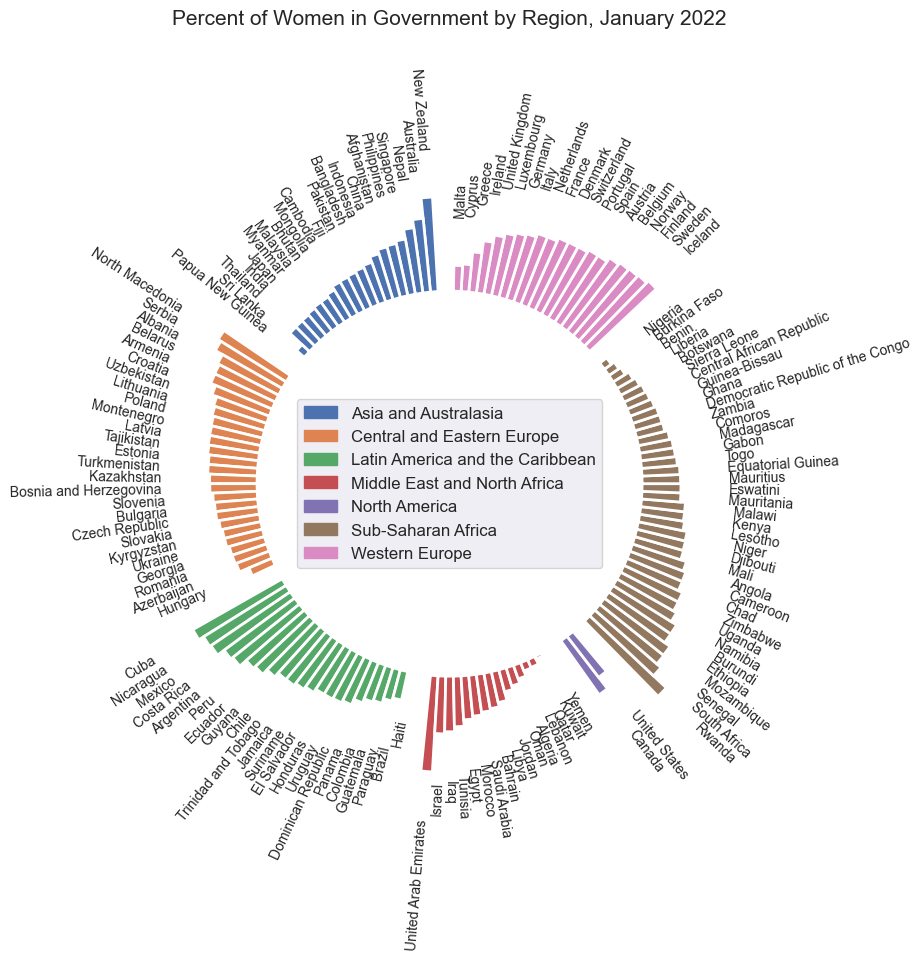

In [43]:
# help creating the circular bar chart from https://www.python-graph-gallery.com/circular-barplot-with-groups
VALUES = circulardata["W%"].values
LABELS = circulardata["Country"].values
GROUP = circulardata["region"].values

OFFSET = np.pi / 2

PAD = 2
ANGLES_N = len(VALUES) + PAD * len(np.unique(GROUP))
ANGLES = np.linspace(0, 2 * np.pi, num=ANGLES_N, endpoint=False)
WIDTH = (2 * np.pi) / len(ANGLES)

offset = 0
IDXS = []
GROUPS_SIZE = [21, 26, 22, 16, 2, 37, 20]
for size in GROUPS_SIZE:
    IDXS += list(range(offset + PAD, offset + size + PAD))
    offset += size + PAD

fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": "polar"})
ax.set_theta_offset(OFFSET)
ax.set_ylim(-1, 1)
ax.set_frame_on(False)
ax.xaxis.grid(False)
ax.yaxis.grid(False)
ax.set_xticks([])
ax.set_yticks([])

COLORS = [f"C{i}" for i, size in enumerate(GROUPS_SIZE) for _ in range(size)]


ax.bar(
    ANGLES[IDXS], VALUES, width=WIDTH, color=COLORS,
    edgecolor="white", linewidth=2
)

add_labels(ANGLES[IDXS], VALUES, LABELS, OFFSET, ax)


plt.title("Percent of Women in Government by Region, January 2022\n\n\n", fontsize=15)

#add in legend
# I tried to make this work through matplotlib but really struggled, so ended up making
# a legend separately. I would like to continue to dig into this problem later.
def unique(sequence):
    seen = set()
    return [x for x in sequence if not (x in seen or seen.add(x))]

unique_colors = unique(COLORS)
unique_regions = unique(GROUP)


asia = mpatches.Patch(color=unique_colors[0], label=unique_regions[0])
ceeurope = mpatches.Patch(color=unique_colors[1], label=unique_regions[1])
latin = mpatches.Patch(color=unique_colors[2], label=unique_regions[2])
mena = mpatches.Patch(color=unique_colors[3], label=unique_regions[3])
namerica = mpatches.Patch(color=unique_colors[4], label=unique_regions[4])
safrica = mpatches.Patch(color=unique_colors[5], label=unique_regions[5])
weurope = mpatches.Patch(color=unique_colors[6], label=unique_regions[6])

plt.legend(handles=[asia, ceeurope, latin, mena, namerica, safrica, weurope]);



## Analysis 4: Visualizing the relationship between democracy index scores and women in government by region, over time

In order to get a better sense of the relationship between the democracy index and the percent women in legislative bodies and how this relationship changes over time, we will create an interactive scatter plot. However, because many governments do not have a upper house or have longer periods of time between elections in upper houses, this led to a high rate of missing data for this column (84% missing). Futhermore, we found that the percent women in upper houses showed a weak correlation of 0.18 to the democracy index (see correlation section above). For these reasons, we will focus this visualzation on the percent of women in lower houses only. 

In [44]:
# plot lower house
# drop upper house annas so that the plot works
scatter_df = df.drop('upper_house_senate_percent_w',axis=1).dropna()
# make figure
fig = px.scatter(scatter_df, 
            x='democracy_index_score',
            y='lower_single_house_percent_w',
            template='plotly_white',    
            #hover_data=['country','year'],
            color='region',
            color_discrete_sequence=px.colors.qualitative.Prism,
            animation_frame='year',
            title= 'Democracy Index vs Percent Women in Lower Parliaments across Time',
            size='lower_single_house_percent_w',
            width=1200,
            height=800
        )

fig.update_xaxes(title_text='Democracy Index Score')
fig.update_yaxes(title_text='Percent Women in Lower Legislative Branches')
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 2000
# fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 25
# write to html file so that it can be added to the github
fig.write_html("visualizations/interactive_scatter.html")

fig.show()